In [5]:
# Uncomment these lines if you need to install the packages
# !pip install numpy
# !pip install opencv-python-headless  # cv2 for headless environments
# !pip install mediapipe
# !pip install tensorflow
# !pip install dlib
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install tqdm
# !pip install requests
# !pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 60.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 113.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 104.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.0
    Uninstalling ml_dtypes-0.5.0:
      Successfully uninstalled ml_dtypes-0.5.0


In [7]:
# THIS TAKES ABOUT 10-15 SECONDS TO RUN

# Core libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np

# Image processing and visualization
import os
import cv2
import mediapipe as mp
import dlib
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for heatmap

# Machine Learning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import backend as K

# Utility for progress bars if we decide to use them
from tqdm import tqdm

# Utility for downloading files from the internet
import requests  

# Confirmation message
print("All essential libraries imported successfully!")


All essential libraries imported successfully!


In [8]:
# This cell downloads and extracts the 'shape_predictor_68_face_landmarks.dat' file, which is a pre-trained model
# for detecting 68 specific facial landmarks. This file is required for facial feature detection tasks, such as
# identifying key facial points for analysis.
# 
# After downloading, the file is extracted from the .bz2 compressed format and saved as 'shape_predictor_68_face_landmarks.dat'.
# This file will be used later in the notebook when we perform landmark-based facial feature extraction.
# 
# For more details about the purpose and function of this file, please refer to the appendix.

# URL for the shape predictor file
url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
output_path = "shape_predictor_68_face_landmarks.dat.bz2"

# Download the .bz2 file
print("Starting download...")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(output_path, "wb") as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Failed to download. Status code:", response.status_code)

# Extract the .bz2 file
import bz2
import shutil

with bz2.BZ2File(output_path, 'rb') as file, open("shape_predictor_68_face_landmarks.dat", 'wb') as f_out:
    shutil.copyfileobj(file, f_out)
print("Extraction complete!")

# Optional: delete the .bz2 file after extraction
import os
os.remove(output_path)
print("Cleanup complete. File is ready for use!")


Starting download...
Download complete!
Extraction complete!
Cleanup complete. File is ready for use!


TypeError: Axes.boxplot() got an unexpected keyword argument 'tick_labels'

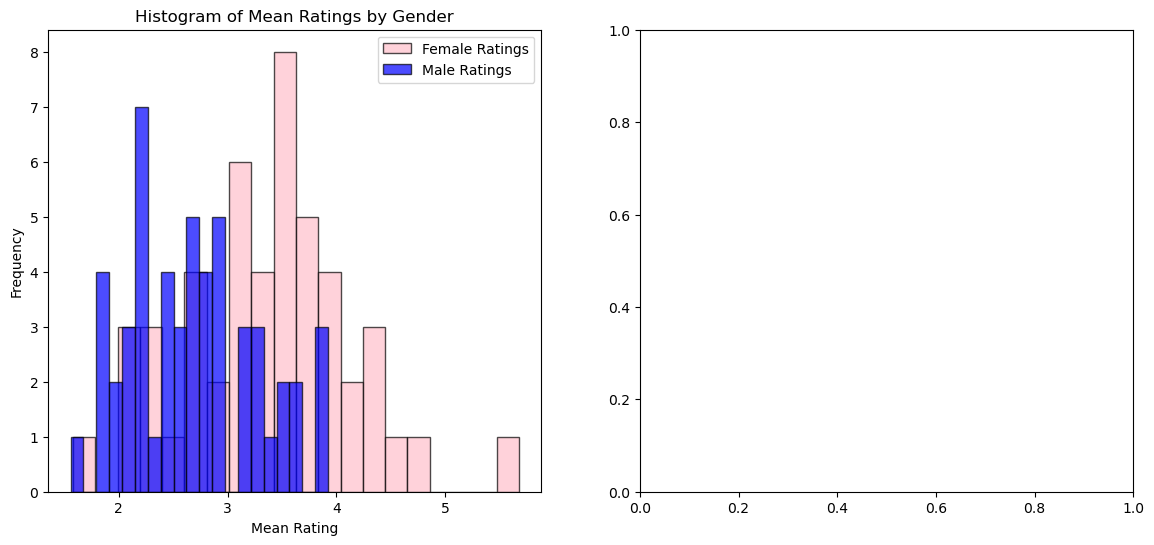

In [9]:
# HISTOGRAMS AND BOX PLOTS OF MALE AND FEMALE RATINGS

# Load the ratings data
ratings_df = pd.read_csv('london_faces_ratings.csv')

# Load the info data to get gender information
info_df = pd.read_csv('london_faces_info.csv')

# Calculate the mean rating for each individual (ignoring the initial columns and focusing on ratings)
mean_ratings = ratings_df.iloc[:, 3:].mean(axis=0)
mean_ratings.index = mean_ratings.index.str.replace('X', '')  # Strip 'X' prefix for matching filenames

# Convert mean ratings to a DataFrame
mean_ratings_df = pd.DataFrame(mean_ratings, columns=['mean_rating']).reset_index()
mean_ratings_df.rename(columns={'index': 'face_id'}, inplace=True)

# Ensure face_id is of type int for the merge
mean_ratings_df['face_id'] = mean_ratings_df['face_id'].astype(int)

# Merge with info_df to get gender information
merged_df = pd.merge(mean_ratings_df, info_df, on='face_id', how='left')

# Separate the mean ratings by gender
female_ratings = merged_df[merged_df['face_gender'] == 'female']['mean_rating']
male_ratings = merged_df[merged_df['face_gender'] == 'male']['mean_rating']

# Plotting the distribution of mean ratings as a histogram and boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
axes[0].hist(female_ratings, bins=20, edgecolor='black', color='pink', alpha=0.7, label='Female Ratings')
axes[0].hist(male_ratings, bins=20, edgecolor='black', color='blue', alpha=0.7, label='Male Ratings')
axes[0].set_title("Histogram of Mean Ratings by Gender")
axes[0].set_xlabel("Mean Rating")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Boxplot
axes[1].boxplot([female_ratings, male_ratings], vert=False, patch_artist=True,
                 tick_labels=['Female', 'Male'],  # Updated parameter name
                 boxprops=dict(facecolor='lightgreen'))
axes[1].set_title("Boxplot of Mean Ratings by Gender")
axes[1].set_xlabel("Mean Rating")

plt.tight_layout()
plt.show()


In [ ]:
# MERGE RATING AND SUBJECT FILES AND FILTER BY SEX (NO PHOTOS MANIPULATED HERE)
# THE FIRST TWO OUTPUTTED TABLES ARE EXCERPTS FROM THE RAW DATASETS
# THE THIRD TABLE IS THE FULL MERGED FILE; THE FOURTH IS FILTERED FOR JUST FEMALES
# FACE_ID REFERENCES THE FIRST SUBJECT, FOR WHICH THERE ARE ABOUT 2500 ROWS OF INDIVIDUAL RATINGS

# Load the datasets
info_df = pd.read_csv('london_faces_info.csv')
ratings_df = pd.read_csv('london_faces_ratings.csv')

# Display the first few rows of each DataFrame to understand their structure
print("Info DataFrame from london_faces_info.csv:")
display(info_df.head())

print("\nRatings DataFrame from london_faces_ratings.csv:")
display(ratings_df.head())

# Reshape ratings_df to have one row per rater and one column for the face_id
ratings_melted = ratings_df.melt(id_vars=['rater_sex', 'rater_sexpref', 'rater_age'], var_name='face_id', value_name='attractiveness_score')

# Clean up the face_id column to remove 'X' and ensure it's string formatted
ratings_melted['face_id'] = ratings_melted['face_id'].str.replace('X', '')

# Convert face_id to integer to match the info_df type
ratings_melted['face_id'] = ratings_melted['face_id'].astype(int)

# Merge the datasets on 'face_id'
merged_df = pd.merge(ratings_melted, info_df, on='face_id', how='left')

# Display the merged DataFrame to confirm the merge
print("\nMerged DataFrame:")
display(merged_df.head())

# Filter for females or males based on the column 'face_gender'
filtered_gender = 'female'  # Set this to 'female' or 'male' as needed
filtered_df = merged_df[merged_df['face_gender'] == filtered_gender]

# Display the filtered DataFrame
print(f"\nFiltered DataFrame for {filtered_gender}s:")
display(filtered_df.head())

# Save the filtered DataFrame to a CSV file for review
filtered_output_file = f'merged_faces_data_{filtered_gender}.csv'
filtered_df.to_csv(filtered_output_file, index=False)

print(f"Filtered data saved to {filtered_output_file}")


In [ ]:
# SHOW TOP-BOTTOM 3 FACES BY ATTRACTIVENESS (USES FILTERED SUBJECT DATAFRAME)

# Calculate the mean attractiveness rating for each individual
mean_ratings = filtered_df.groupby('face_id')['attractiveness_score'].mean()

# Reset the index to have face_id as a column
mean_ratings = mean_ratings.reset_index()

# Find the top 3 and bottom 3 rated individuals overall
top_rated = mean_ratings.nlargest(3, 'attractiveness_score')
bottom_rated = mean_ratings.nsmallest(3, 'attractiveness_score')

# Function to load and preprocess an image by filename
def load_image(face_id):
    face_id_str = str(face_id).zfill(3)  # Ensure face_id has leading zeros
    image_path = os.path.join('neutral_front', face_id_str + '_03.jpg')
    image = cv2.imread(image_path)
    if image is not None:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    return None

# Display the images in a 2x6 grid (2 rows for top and bottom)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Top rated images
for i, image_id in enumerate(top_rated['face_id']):
    image = load_image(image_id)
    if image is not None:
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Top {i+1} Rated: ID {image_id}\nRating: {top_rated['attractiveness_score'].iloc[i]:.2f}")
    axes[0, i].axis('off')

# Bottom rated images
for i, image_id in enumerate(bottom_rated['face_id']):
    image = load_image(image_id)
    if image is not None:
        axes[1, i].imshow(image)
        axes[1, i].set_title(f"Bottom {i+1} Rated: ID {image_id}\nRating: {bottom_rated['attractiveness_score'].iloc[i]:.2f}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# DISPLAYS THE STANDARDIZED IMAGES OF THE 49 FEMALE SUBJECTS
# THESE IMAGES ARE SPECIFICALLY FROM THE NEUTRAL_FRONT SUBFOLDER IN THE ACTIVE DIRECTORY
# THE ID CORRESPONDS TO THE FACE_ID AND FIRST 3 DIGITS OF THE JPG FILE NAMES

# Extract the relevant image IDs and zero-fill to match filename format
filtered_image_ids = set(filtered_df['face_id'].astype(str).str.zfill(3))

# Define a function to preprocess an image
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to read image at {image_path}. Skipping.")
            return None  # Return None if the image can't be read
        image = cv2.resize(image, (1000, 1000))  # Resize image for consistent resolution
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        return gray_image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# List to store processed images and their paths
processed_images = []

# Process each image in the 'neutral_front' folder matching filtered image IDs
for subdir, _, files in os.walk('.'):  # Start from the current directory
    for file in files:
        if file.endswith('.jpg'):
            image_id = file.split('_')[0]
            # Check if the image is in 'neutral_front' and matches a filtered ID
            if 'neutral_front' in subdir and image_id in filtered_image_ids:
                image_path = os.path.join(subdir, file)
                gray_image = preprocess_image(image_path)
                if gray_image is not None:
                    processed_images.append((image_id, image_path, gray_image))  # Store ID, path, and image

# Sort processed images by image ID in ascending order
processed_images.sort(key=lambda x: int(x[0]))

# Display up to 50 processed images in a grid
max_images = 50
num_images = min(len(processed_images), max_images)
fig, axes = plt.subplots(num_images // 5 + (num_images % 5 > 0), 5, figsize=(15, num_images * 3 // 5))
axes = axes.flatten() if num_images > 1 else [axes]

for i in range(num_images):
    image_id, image_path, gray_image = processed_images[i]
    axes[i].imshow(gray_image, cmap='gray')
    axes[i].set_title(f"ID: {image_id}")
    axes[i].axis('off')

# Hide any remaining empty subplots
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# LOADS THE DLIB FACE DETECTOR PACKAGE AND FACIAL LANDMARK DETECTOR
# DISPLAYS X,Y PIXEL COORDINATES FOR THE 68 DEFINED FACIAL LANDMARKS
# OVERLAYS THE LANDMARKS WITH THE DLIB LANDMARK NUMBERING ON A FACE FOR ILLUSTRATION PURPOSES

# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Load the filtered DataFrame containing the IDs of female faces
filtered_gender = 'female'
filtered_df = merged_df[merged_df['face_gender'] == filtered_gender]
filtered_image_ids = set(filtered_df['face_id'].astype(str).str.zfill(3))

# Define a function to extract facial landmarks from a grayscale image
def get_landmarks(gray_image):
    faces = detector(gray_image)
    if len(faces) > 0:
        landmarks = predictor(gray_image, faces[0])  # Use the first detected face
        coords = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
        return coords
    return None

# Updated function to display the image with landmarks overlaid and numbered, and coordinates printed above
def display_landmarks(image, landmarks, image_path, scale=1.0):
    # Format and print coordinates with landmark numbers
    formatted_landmarks = [f"{i}:({x}, {y})" for i, (x, y) in enumerate(landmarks)]
    print(f"Facial landmarks extracted from: {image_path}")
    print("Facial Landmarks:", formatted_landmarks)
    print("\n")  # Add extra spacing for readability

    # Set a larger figure size by scale for high readability
    plt.figure(figsize=(10 * scale, 10 * scale))
    plt.imshow(image, cmap='gray')  # Display the image in grayscale

    # Overlay landmarks with numbering for each point
    for i, (x, y) in enumerate(landmarks):
        plt.plot(x, y, 'ro', markersize=8 * scale)  # Slightly larger dot size
        plt.text(x, y, str(i), color='white', fontsize=12 * scale, ha='center', va='center', backgroundcolor='red')

    # Add a title with the image path
    plt.title(f"Landmarks for {os.path.basename(image_path)}", fontsize=15 * scale)
    plt.axis('off')  # Turn off axis for a cleaner look
    plt.show()

# Sort the files by ID to ensure the lowest numbered file is processed first
image_folder = './neutral_front'  # Set your folder path here
filtered_files = sorted([file for file in os.listdir(image_folder) if file.endswith('.jpg') and file.split('_')[0] in filtered_image_ids])

# Process images in sorted order and display the first with landmarks
for file in filtered_files:
    image_id = file.split('_')[0]  # Extract the ID part from the filename
    image_path = os.path.join(image_folder, file)
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract landmarks
    landmarks = get_landmarks(gray_image)

    # Display the first image with landmarks, scaled as requested
    if landmarks:
        display_landmarks(gray_image, landmarks, image_path, scale=2)  # Adjust scale as needed
        break  # Stop after displaying the first image with landmarks


In [ ]:
# ASSIGNS PLAIN ENGLISH LABELS TO KEY LANDMARKS
# MEASURES EUCLIDEAN DISTANCES BETWEEN THE X,Y COORDINATES OF THE KEY LANDMARKS
# COMPUTES FACIAL PROPORTIONS AND RATIOS USED IN OUR MODEL
# PUTS ALL OF THESE MEASURES INTO DATAFRAMES FOR LATER USE

# Define a function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Function to compute comprehensive facial features and distances based on corrected 68 facial landmarks
def calculate_all_features(landmarks):
    if landmarks is None:
        return None

    # Key landmarks with corrected indices
    key_landmarks = {
        'left_temple': np.array(landmarks[0]),
        'right_temple': np.array(landmarks[16]),
        'chin_tip': np.array(landmarks[8]),
        'nose_tip': np.array(landmarks[30]),
        'nose_top': np.array(landmarks[27]),
        'nose_bottom': np.array(landmarks[33]),
        'nose_left': np.array(landmarks[31]),
        'nose_right': np.array(landmarks[35]),
        'left_eye_outer': np.array(landmarks[36]),
        'left_eye_inner': np.array(landmarks[39]),
        'right_eye_outer': np.array(landmarks[45]),
        'right_eye_inner': np.array(landmarks[42]),
        'mouth_left_corner': np.array(landmarks[48]),
        'mouth_right_corner': np.array(landmarks[54]),
        'upper_lip_center': np.array(landmarks[51]),
        'lower_lip_center': np.array(landmarks[57]),
        'glabella': np.array(landmarks[27]),
    }

    # Basic distances
    basic_distances = {
        'face_length': euclidean_distance(key_landmarks['nose_top'], key_landmarks['chin_tip']),
        'face_width': euclidean_distance(key_landmarks['left_temple'], key_landmarks['right_temple']),
        'eye_distance_inner': euclidean_distance(key_landmarks['left_eye_inner'], key_landmarks['right_eye_inner']),
        'eye_distance_outer': euclidean_distance(key_landmarks['left_eye_outer'], key_landmarks['right_eye_outer']),
        'mouth_width': euclidean_distance(key_landmarks['mouth_left_corner'], key_landmarks['mouth_right_corner']),
        'nose_width': euclidean_distance(key_landmarks['nose_left'], key_landmarks['nose_right']),
        'nose_length': euclidean_distance(key_landmarks['nose_top'], key_landmarks['nose_bottom']),
        'lip_height': euclidean_distance(key_landmarks['upper_lip_center'], key_landmarks['lower_lip_center']),
        'left_eye_width': euclidean_distance(key_landmarks['left_eye_outer'], key_landmarks['left_eye_inner']),
        'interocular_distance': euclidean_distance(key_landmarks['left_eye_outer'], key_landmarks['right_eye_outer']),
    }

    # Symmetry-related distances
    symmetry_distances = {
        'left_eye_to_nose_tip': euclidean_distance(key_landmarks['left_eye_inner'], key_landmarks['nose_tip']),
        'right_eye_to_nose_tip': euclidean_distance(key_landmarks['right_eye_inner'], key_landmarks['nose_tip']),
        'left_mouth_to_nose_tip': euclidean_distance(key_landmarks['mouth_left_corner'], key_landmarks['nose_tip']),
        'right_mouth_to_nose_tip': euclidean_distance(key_landmarks['mouth_right_corner'], key_landmarks['nose_tip']),
        'left_nose_to_nose_tip': euclidean_distance(key_landmarks['nose_left'], key_landmarks['nose_tip']),
        'right_nose_to_nose_tip': euclidean_distance(key_landmarks['nose_right'], key_landmarks['nose_tip']),
        'left_eye_to_glabella': euclidean_distance(key_landmarks['left_eye_outer'], key_landmarks['glabella']),
        'right_eye_to_glabella': euclidean_distance(key_landmarks['right_eye_outer'], key_landmarks['glabella']),
    }

    # Feature ratios and proportions used in analysis
    features = {
        'golden_ratio': basic_distances['face_length'] / basic_distances['face_width'] if basic_distances['face_width'] != 0 else np.nan,
        'eye_to_mouth_ratio': basic_distances['eye_distance_inner'] / basic_distances['mouth_width'] if basic_distances['mouth_width'] != 0 else np.nan,
        'eye_spacing_ratio': basic_distances['eye_distance_outer'] / basic_distances['face_width'] if basic_distances['face_width'] != 0 else np.nan,
        'nose_to_face_length_ratio': basic_distances['nose_length'] / basic_distances['face_length'] if basic_distances['face_length'] != 0 else np.nan,
        'mouth_to_nose_ratio': basic_distances['mouth_width'] / basic_distances['nose_width'] if basic_distances['nose_width'] != 0 else np.nan,
        'lip_height_to_mouth_ratio': basic_distances['lip_height'] / basic_distances['mouth_width'] if basic_distances['mouth_width'] != 0 else np.nan,
        
        # Symmetry ratios using precomputed distances
        'eye_symmetry_ratio': abs(symmetry_distances['left_eye_to_nose_tip'] / symmetry_distances['right_eye_to_nose_tip'] - 1) if symmetry_distances['right_eye_to_nose_tip'] != 0 else np.nan,
        'mouth_symmetry_ratio': abs(symmetry_distances['left_mouth_to_nose_tip'] / symmetry_distances['right_mouth_to_nose_tip'] - 1) if symmetry_distances['right_mouth_to_nose_tip'] != 0 else np.nan,
        'nose_symmetry_ratio': abs(symmetry_distances['left_nose_to_nose_tip'] / symmetry_distances['right_nose_to_nose_tip'] - 1) if symmetry_distances['right_nose_to_nose_tip'] != 0 else np.nan,
        
        'eye_positioning_ratio': basic_distances['left_eye_width'] / basic_distances['eye_distance_inner'] if basic_distances['eye_distance_inner'] != 0 else np.nan,
        'nose_dimensions_ratio': basic_distances['nose_length'] / basic_distances['nose_width'] if basic_distances['nose_width'] != 0 else np.nan,
        'mouth_to_face_width_ratio': basic_distances['mouth_width'] / basic_distances['face_width'] if basic_distances['face_width'] != 0 else np.nan,
        'eye_mouth_interaction': (basic_distances['eye_distance_outer'] / basic_distances['face_length']) * (basic_distances['mouth_width'] / basic_distances['face_width']) if basic_distances['face_length'] != 0 and basic_distances['face_width'] != 0 else np.nan,        
    }

    return features, basic_distances, symmetry_distances, key_landmarks

# Modified process_features function
def process_features(processed_images, filtered_df, num_subjects=None):
    if not isinstance(processed_images, list):
        raise ValueError("processed_images must be a list.")
    
    if num_subjects is not None and (not isinstance(num_subjects, int) or num_subjects < 0):
        raise ValueError("num_subjects must be a non-negative integer.")

    if 'face_id' not in filtered_df.columns:
        print("Error: 'face_id' column is missing in the filtered DataFrame.")
        return pd.DataFrame()

    filtered_df = filtered_df.copy()
    filtered_df['face_id'] = filtered_df['face_id'].astype(str).str.zfill(3)
    valid_face_ids = set(filtered_df['face_id'])

    features_list = []

    for index, item in enumerate(processed_images):
        if num_subjects is not None and index >= num_subjects:
            break

        if not isinstance(item, tuple) or len(item) != 3:
            print(f"Warning: Skipping an item in processed_images that does not have exactly three elements: {item}")
            continue

        _, image_path, gray_image = item
        face_id = os.path.basename(image_path).split('_')[0].zfill(3)
        
        if 'neutral_front' not in image_path or face_id not in valid_face_ids:
            continue

        landmarks = get_landmarks(gray_image)
        if landmarks is None:
            print(f"No landmarks found for image: {image_path}")
            continue

        # Calculate features, distances, and landmarks
        features, basic_distances, symmetry_distances, key_landmarks = calculate_all_features(landmarks)

        # Add metadata and calculated values to the features dictionary
        features['face_id'] = face_id
        features['image_path'] = image_path
        
        # Combine all results into one dictionary
        full_data = {**features, **basic_distances, **symmetry_distances, **key_landmarks}

        features_list.append(full_data)

    all_features_df = pd.DataFrame(features_list)

    if not all_features_df.empty:
        display(all_features_df.head())
    else:
        print("No features extracted from the provided images.")

    return all_features_df

# Example usage:
# Assuming 'filtered_df' is the DataFrame that contains only the selected 'face_id's for the required gender
all_features_df = process_features(processed_images, filtered_df)


In [ ]:
# FOR AUDITING PURPOSES, THIS SHOWS WHAT GOES INTO A PARTICULAR FEATURE
# THIS IS NOT FULLY FLESHED OUT AND VALIDATED
# THE INTENTION IS TO GENERATE SOMETHING LIKE THIS, SOMEWHAT MORE DYNAMICALLY, FOR ALL THE FEATURES
# SOME OTHER FAILED ATTEMPTS AT THIS ARE DOWN AT THE BOTTOM OF THE NOTEBOOK DESIGNATED AS MARKDOWN CELLS SO THEY DON'T RUN INADVERTENTLY

import os
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Define a function to extract facial landmarks from a grayscale image
def get_landmarks(gray_image):
    faces = detector(gray_image)
    if len(faces) > 0:
        landmarks = predictor(gray_image, faces[0])  # Use the first detected face
        coords = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
        return coords
    return None

# Function to display relevant landmarks, names, and lines for interpreting "lip_to_face_proportion"
def display_lip_to_face_proportion(image, key_landmarks, basic_distances, features, image_path):
    plt.figure(figsize=(11, 11))  # Single plot for image

    # Display the image with relevant landmarks and lines
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Only show upper lip center, lower lip center, nose top, and chin tip landmarks
    relevant_landmarks = {
        'nose_top': key_landmarks['nose_top'],
        'upper_lip_center': key_landmarks['upper_lip_center'],
        'lower_lip_center': key_landmarks['lower_lip_center'],
        'chin_tip': key_landmarks['chin_tip']
    }

    # Plot relevant landmarks and annotate with names
    for name, (x, y) in relevant_landmarks.items():
        plt.plot(x, y, 'ro', markersize=6)
        offset = 25
        plt.text(x + offset, y, name, color='red', fontsize=10, ha='center', backgroundcolor='white')

    # Draw lip height line (blue) and face length line (green)
    lip_height_points = (relevant_landmarks['upper_lip_center'], relevant_landmarks['lower_lip_center'])
    face_length_points = (relevant_landmarks['nose_top'], relevant_landmarks['chin_tip'])
    plt.plot(
        [lip_height_points[0][0], lip_height_points[1][0]],
        [lip_height_points[0][1], lip_height_points[1][1]],
        'b-', linewidth=1.5
    )
    plt.plot(
        [face_length_points[0][0], face_length_points[1][0]],
        [face_length_points[0][1], face_length_points[1][1]],
        'g-', linewidth=1.5
    )

    # Annotate the "lip_to_face_proportion" at the top left corner
    lip_to_face_proportion = features.get('lip_to_face_proportion', "N/A")
    plt.text(
        20, 40, f"Lip to Face Proportion: {lip_to_face_proportion:.2f}" if isinstance(lip_to_face_proportion, (float, int)) else "Lip to Face Proportion: N/A",
        color='white', fontsize=12, backgroundcolor='black'
    )

    # Display formulas and measurements
    formula_text = (
        "Formulas:\n"
        "lip_to_face_proportion = lip_height / face_length\n"
        "lip_height = distance between [51] and [57]\n"
        "face_length = distance between [27] and [8]"
    )
    plt.text(
        20, 400, formula_text, color='white', fontsize=10, backgroundcolor='black', ha='left'
    )
    face_length = basic_distances.get('face_length', None)
    lip_height = basic_distances.get('lip_height', None)
    distance_text_y = 180
    line_spacing = 50
    if face_length is not None:
        plt.text(
            60, distance_text_y, f"Face Length: {face_length:.2f}",
            color='green', fontsize=10, backgroundcolor='white'
        )
        distance_text_y += line_spacing
    if lip_height is not None:
        plt.text(
            60, distance_text_y, f"Lip Height: {lip_height:.2f}",
            color='blue', fontsize=10, backgroundcolor='white'
        )

    plt.title(f"Landmarks and Lip to Face Proportion for {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Load the filtered DataFrame and get valid female image IDs
filtered_df = pd.read_csv('merged_faces_data_female.csv')  # Adjust to your actual filtered DataFrame file
filtered_df['face_id'] = filtered_df['face_id'].astype(str).str.zfill(3)
valid_face_ids = set(filtered_df['face_id'])

# Folder containing images and sorting files by name
image_folder = './neutral_front'
filtered_files = sorted([file for file in os.listdir(image_folder) if file.endswith('.jpg') and file.split('_')[0] in valid_face_ids])

# Iterate through each filtered image and display landmarks for the first matching file
for file in filtered_files:
    image_path = os.path.join(image_folder, file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {file}")
        continue
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    landmarks = get_landmarks(gray_image)

    if landmarks:
        # Compute distances and features using pre-defined key landmarks
        features, basic_distances, symmetry_distances, key_landmarks = calculate_all_features(landmarks)
        display_lip_to_face_proportion(image, key_landmarks, basic_distances, features, image_path)
        break  # Stop after displaying the first image to confirm functionality
    else:
        print(f"No landmarks found for image: {file}")


In [ ]:
# Reshape the ratings data for analysis

# Melt the ratings_df to make each rating in a single column under a new 'image_id' column
ratings_long_df = ratings_df.melt(
    id_vars=['rater_sex', 'rater_sexpref', 'rater_age'],
    var_name='image_id',
    value_name='attractiveness_score'
)

# Standardize 'image_id' by removing 'X' and padding to match feature image IDs
ratings_long_df['image_id'] = ratings_long_df['image_id'].str.replace('X', '').str.zfill(3)

# Display a preview of the reshaped DataFrame
display(ratings_long_df.head(3))


In [ ]:
# THIS CODE MERGES THE RATINGS DATA WITH THE FACIAL FEATURES
# OUTPUTS A LARGE DATAFRAME AND CSV FILE (100K+ ROWS) TO THE ACTIVE DRIVE
# TAKES 30-60 SECONDS TO RUN

# Rename 'face_id' to 'image_id' in all_features_df to match ratings_long_df
all_features_df = all_features_df.rename(columns={'face_id': 'image_id'})

# Define a set of dummy landmarks for feature extraction
dummy_landmarks = [(0, 0)] * 68  # Minimal placeholder for 68 landmarks

# Use dummy landmarks to get the structure of features for dynamic feature extraction
features, _, _, _ = calculate_all_features(dummy_landmarks)  # Retrieve the features dictionary structure
dynamic_feature_columns = list(features.keys())  # Extract feature keys dynamically

# Add 'image_id' and 'attractiveness_score' to the list for merging and preview
selected_columns = dynamic_feature_columns + ['image_id', 'attractiveness_score']

# Merge the DataFrames
merged_df = all_features_df.merge(ratings_long_df, on='image_id', how='left')
    
# Adjust display options for a cleaner table output
pd.set_option('display.max_columns', None)  # Display all columns (useful when needed)
pd.set_option('display.width', 1000)  # Set an arbitrary width to prevent wrapping

print(f"\nThis code takes 30-60 seconds to fully execute; wait for message about 'Merged data saved...'\n")

# Display only selected columns for a clean preview
preview_df = merged_df[selected_columns]
display(preview_df.head(3))
display(preview_df.tail(3))
    
# Save the merged DataFrame as a CSV, ensuring numeric columns are saved correctly
merged_output_file = 'merged_facial_features_with_ratings.csv'
merged_df.to_csv(merged_output_file, index=False, float_format='%.4f')
print(f"Merged data saved to {merged_output_file}.\n")


In [ ]:
# AVERAGES THE ATTRACTIVENESS RATINGS FOR EACH SUBJECT
# ALSO CONDENDSES THE FEATURES BY AVERAGING THEM FOR EACH SUBJECT
# OUTPUTS A SMALL DATAFRAME AND CSV FILE TO THE ACTIVE DRIVE

# Dynamically retrieve the feature columns
# Using the feature columns dynamically extracted from `calculate_all_features`
feature_columns = dynamic_feature_columns + ['attractiveness_score']

# Calculate the mean attractiveness score and mean values for each feature dynamically
aggregated_df = merged_df.groupby('image_id')[feature_columns].mean().reset_index()

# Rename the column for clarity
aggregated_df.rename(columns={'attractiveness_score': 'mean_attractiveness_score'}, inplace=True)

# Display the first few rows of the aggregated DataFrame
print("Raw Value DataFrame:")
display(aggregated_df.head(3))
display(aggregated_df.tail(3))

# Save the aggregated DataFrame to a CSV file in the current directory
output_file = 'aggregated_attractiveness_scores.csv'
aggregated_df.to_csv(output_file, index=False)
print(f"Aggregated data saved to {output_file}.")


In [ ]:
# NORMALIZED VARIABLES (0 TO 1)
# USES NORMALIZATION FROM 2.2.2 OF Human-like evaluation by facial attractiveness intelligent machine.pdf

# Exclude 'mean_attractiveness_score' from normalization
features_to_normalize = [col for col in dynamic_feature_columns if col != 'mean_attractiveness_score']

# Apply Min-Max normalization to each selected feature
for feature in features_to_normalize:
    X_min = aggregated_df[feature].min()
    X_max = aggregated_df[feature].max()
    aggregated_df[feature] = (aggregated_df[feature] - X_min) / (X_max - X_min)

# Display the normalized DataFrame
print("Normalized Value DataFrame:")
display(aggregated_df.head(3))
display(aggregated_df.tail(3))

# Save the normalized DataFrame to a CSV file in the current directory
normalized_output_file = 'normalized_attractiveness_scores.csv'
aggregated_df.to_csv(normalized_output_file, index=False)
print(f"Normalized data saved to {normalized_output_file}.")


In [ ]:
# CORRELATION MATRIX OF ALL THE VARIABLES
# THE CORRELATIONS WITH ATTRACTIVENESS ARE IN THE BOTTOM ROW

# Ensure mean_attractiveness_score is included in the correlation calculation
correlation_matrix = aggregated_df.drop(columns=['image_id']).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and the coolwarm colormap for typical correlation shading
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, 
            fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)

# Set title for the heatmap
plt.title("Lower Triangle Correlation Matrix of Standardized Facial Features and Attractiveness")
plt.show()


In [ ]:
# TEST FOR PREDICTIVENESS OF THE VARIABLE SET
# GENERATES SMALLER SET OF EXPLANATORY VARIABLES WITH RELATIVELY HIGH ASSOCIATION WITH ATTRACTIVENESS 
# AND THAT ARE NOT HIGHLY CORRELATED WITH ONE ANOTHER

# Step 1: Calculate correlations and p-values with `mean_attractiveness_score`
def calculate_correlations_with_pvalues(df, target):
    correlations = {}
    p_values = {}
    for column in df.columns:
        if column != target:
            corr, p_value = stats.pearsonr(df[column], df[target])
            correlations[column] = corr
            p_values[column] = p_value
    return pd.DataFrame({"Correlation to Attractiveness": correlations, "P-value of Correlation": p_values})

# Calculate correlation and p-value with `mean_attractiveness_score`
correlations_df = calculate_correlations_with_pvalues(aggregated_df.drop(columns=['image_id']), 'mean_attractiveness_score')

# Step 2: Filter significant features based on a p-value threshold (0.30)
significant_features = correlations_df[correlations_df['P-value of Correlation'] < 0.30].index.tolist()

# Create a subset DataFrame with only significant features for further analysis
filtered_df = aggregated_df[significant_features + ['mean_attractiveness_score']]

# Define a high correlation threshold to filter out highly correlated features
high_corr_threshold = 0.69
to_remove = []

# Step 3: Identify highly correlated features and prioritize keeping those with lower p-values
correlation_matrix = filtered_df.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            # Check p-values and keep the feature with the lower p-value
            if correlations_df.loc[feature_i, 'P-value of Correlation'] < correlations_df.loc[feature_j, 'P-value of Correlation']:
                if feature_j not in to_remove:
                    to_remove.append(feature_j)
            else:
                if feature_i not in to_remove:
                    to_remove.append(feature_i)

# Final selected features by excluding those in `to_remove`
selected_features = [feature for feature in significant_features if feature not in to_remove]

# Step 4: Update the selection status in the correlations DataFrame
correlations_df['Selected'] = correlations_df.index.isin(selected_features)

# Sort the DataFrame by P-value in ascending order
correlations_df = correlations_df.sort_values(by="P-value of Correlation")

# Display the final statistics for each feature
print("\nDetailed Statistics for Each Feature Sorted by P-Value:\n")
display(correlations_df)

# Optionally, save the results to a CSV for documentation
correlations_df.to_csv('feature_statistics_with_selection.csv', index=True)
print("Feature statistics saved to 'feature_statistics_with_selection.csv'\n")


In [ ]:
# CORRELATION MATRIX OF VARIABLES BELIEVED TO BE PREDICTIVE (SELECTED IN THE PREVIOUS CODE BLOCK)

# Filter the aggregated DataFrame to include only selected features
selected_features = correlations_df[correlations_df['Selected']].index.tolist()
selected_df = aggregated_df[selected_features]

# Calculate the correlation matrix for the selected features
correlation_matrix = selected_df.corr()

# Mask only the upper triangle (excluding the diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the modified mask and a cool-to-warm color palette
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap="coolwarm",  # Cool-to-warm palette
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=-1, vmax=1  # Set range from -1 to 1 for correlation values
)

# Add title and display the plot
plt.title("Lower Triangle Correlation Matrix of Selected Features (Including Diagonal)")
plt.show()


In [ ]:
# REGRESSION USING VARIABLES BELIEVED TO BE PREDICTIVE
# REMEMBER THAT THE SQUARE ROOT OF THE R-SQUARED IS THE CORRELATION OF THE MODEL WITH ATTRACTIVNESS
# FOR EXAMPLE, A .273 R-SQ EQUATES TO A MODERATE 0.52 CORRELATION

# Prepare the data
# Ensure 'mean_attractiveness_score' is in the DataFrame for regression
dependent_variable = 'mean_attractiveness_score'
X = aggregated_df[selected_features]  # Use the selected features as predictors
y = aggregated_df[dependent_variable]  # Set mean attractiveness score as the dependent variable

# Add a constant to the predictors to include an intercept in the model
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())


In [ ]:
# REGRESSION THAT SPLITS THE SUBJECTS INTO A TRAINING SET AND A TEST SET
# THE TEST SET IS 20% OF THE SUBJECTS FOR A TOTAL OF 10 SINCE THERE WERE ONLY 49 FEMALES TO START WITH

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Define X as the explanatory variables (all columns except 'image_id' and 'mean_attractiveness_score')
X = merged_selected_df.drop(columns=['image_id', 'mean_attractiveness_score'])
y = merged_selected_df['mean_attractiveness_score']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Add a constant to the predictors in the training set to include an intercept in the model
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)  # Also add a constant to the test set for prediction

# Perform the regression on the training data
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the regression results
print(model.summary())

# Make predictions on the test set
y_pred = model.predict(X_test)

# Optional: Evaluate the model on the test set (e.g., calculating R-squared for test set)
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Calculate R-squared and RMSE for test set
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2_test}")
print(f"Test RMSE: {rmse_test}")


In [ ]:
# GENERATES A SCATTERPLOT WITH PREDICTED ATTRACTIVENESS BASED ON REGRESSION MODEL ON THE Y-AXIS
# AND ACTUAL ATTRACTIVENSS ON THE X-AXIS

# Generate predicted values from the regression model
predicted_values = model.predict(X)

# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y, predicted_values, color='skyblue', label="Data Points", alpha=0.7)
plt.xlabel("Actual Attractiveness Rating")
plt.ylabel("Predicted Attractiveness Rating")

# Add a line of best fit
m, b = np.polyfit(y, predicted_values, 1)
plt.plot(y, m * y + b, color="blue", linewidth=2, label=f"Best Fit Line: y = {m:.2f}x + {b:.2f}")

# Display R-squared on the plot
r_squared = model.rsquared
plt.title(f"Predicted vs. Actual Attractiveness Ratings (R² = {r_squared:.2f})")

# Construct the regression formula based on model coefficients, using iloc to access values by position
formula_terms = [f"{model.params.iloc[i]:.2f} * {name}" for i, name in enumerate(X.columns[1:], start=1)]
formula = f"y = {model.params.iloc[0]:.2f} + " + " + ".join(formula_terms)
#plt.text(2, 4, formula, fontsize=10, color='blue', backgroundcolor='white')  # Adjust position as necessary

# Add legend
#plt.legend(loc="upper left")

# Show the plot
plt.show()


In [ ]:
# SAME SCATTERPLOT, BUT WITH PHOTOS FOR REFERENCE LIKE IN FIGURE 12 OF
# Human-like evaluation by facial attractiveness intelligent machine.pdf

# Load image paths with image_ids for filtering
image_folder = './neutral_front'
image_paths = {file.split('_')[0].zfill(3): os.path.join(image_folder, file)
               for file in os.listdir(image_folder) if file.endswith('.jpg')}

# Generate predicted values from the regression model (assuming model and X are defined)
predicted_values = model.predict(X)

# Set up the plot size, limits, and DPI for higher resolution
plt.figure(figsize=(12, 12), dpi=150)
plt.xlim([min(y) - 0.5, max(y) + 0.5])
plt.ylim([min(predicted_values) - 0.5, max(predicted_values) + 0.5])

# Plot each image at its corresponding actual and predicted coordinates
for actual, predicted, image_id in zip(y, predicted_values, aggregated_df['image_id']):
    img_path = image_paths.get(image_id.zfill(3))
    if img_path:
        img = Image.open(img_path)
        
        # Resize the image using high-quality resampling, and set size to 50x50 for better visibility
        img = img.resize((50, 50), resample=Image.LANCZOS)

        # Place each image at its actual vs. predicted location
        plt.imshow(img, extent=(actual - 0.25, actual + 0.25, predicted - 0.25, predicted + 0.25))

# Add the best-fit line and other details
m, b = np.polyfit(y, predicted_values, 1)
plt.plot(y, m * y + b, color="blue", linewidth=2, label=f"Best Fit Line: y = {m:.2f}x + {b:.2f}")

# Add labels and title
plt.xlabel("Actual Attractiveness Rating")
plt.ylabel("Predicted Attractiveness Rating")
r_squared = model.rsquared
plt.title(f"Predicted vs. Actual Attractiveness Ratings (R² = {r_squared:.2f})")
plt.legend(loc="upper left")

# Show the plot
plt.show()


In [ ]:
# SCATTERPLOT OF THE TEST SET (NEED TO REFACTOR THIS CODE BECAUSE A LOT OF IT IS DUPLICATIVE)

# Retain image_id separately
image_ids = merged_selected_df['image_id']

# Define X as the explanatory variables (all columns except 'image_id' and 'mean_attractiveness_score')
X = merged_selected_df.drop(columns=['image_id', 'mean_attractiveness_score'])
y = merged_selected_df['mean_attractiveness_score']

# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test, image_id_train, image_id_test = train_test_split(
    X, y, image_ids, test_size=0.25, random_state=42)

# Add a constant to the predictors in the training set to include an intercept in the model
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)  # Also add a constant to the test set for prediction

# Perform the regression on the training data
model = sm.OLS(y_train, X_train).fit()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot setup
image_folder = './neutral_front'
image_paths = {file.split('_')[0].zfill(3): os.path.join(image_folder, file)
               for file in os.listdir(image_folder) if file.endswith('.jpg')}

# Set up the plot size, limits, and DPI for higher resolution
plt.figure(figsize=(12, 12), dpi=150)
plt.xlim([min(y_test) - 0.5, max(y_test) + 0.5])
plt.ylim([min(y_pred) - 0.5, max(y_pred) + 0.5])

# Plot each image at its corresponding actual and predicted coordinates
for actual, predicted, image_id in zip(y_test, y_pred, image_id_test):
    img_path = image_paths.get(str(image_id).zfill(3))
    if img_path:
        img = Image.open(img_path)
        
        # Resize the image to approximately one-third smaller (e.g., 70x70)
        img = img.resize((70, 70), resample=Image.LANCZOS)

        # Place each image at its actual vs. predicted location
        plt.imshow(img, extent=(actual - 0.25, actual + 0.25, predicted - 0.25, predicted + 0.25), aspect='auto')

# Add the best-fit line
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color="blue", linewidth=2, label=f"Best Fit Line: y = {m:.2f}x + {b:.2f}")

# Add labels and title
plt.xlabel("Actual Attractiveness Rating")
plt.ylabel("Predicted Attractiveness Rating")
plt.title(f"Predicted vs. Actual Attractiveness Ratings (Test Set)")

# Show the plot
plt.legend(loc="upper left")
plt.show()


In [ ]:
# GENERATES A TABLE WITH PREDICTED ATTRACTIVENESS USING NORMALIZED FEATURES AND REGRESSION COEFFICIENTS
# THIS IS MOSTLY FOR AUDITING PURPOSES
# CURRENTLY USING THE FULL DATA SET

# Display the full table with the constant and explanatory variables and beta coefficients
coefficients_df = pd.DataFrame({
    "Variable": ["Constant"] + list(X.columns[1:]),
    "Coefficient": [model.params.iloc[0]] + list(model.params.iloc[1:])
})
display(coefficients_df)

# Save the coefficient table to CSV
coefficients_df.to_csv("regression_coefficients.csv", index=False)

# Create a table of actual vs. predicted values and include normalized variable values for each subject
# Add 'image_id' to the results DataFrame for identification, ensuring leading zeros
results_df = pd.DataFrame({
    "image_id": aggregated_df['image_id'].astype(str).str.zfill(3),  # Convert to string and zero-pad to 3 digits
    "Actual": y,
    "Predicted": predicted_values
})

# Add each normalized predictor variable to results_df
normalized_X = X.drop(columns="const")  # Drop constant column to get only predictor variables
for column in normalized_X.columns:
    results_df[column] = normalized_X[column].values

# Add the constant and coefficients to each row
results_df["Constant"] = model.params.iloc[0]
for i, name in enumerate(X.columns[1:], start=1):
    results_df[f"Coef_{name}"] = model.params.iloc[i]

# Display the final results DataFrame without converting to numeric (preserving 'image_id' as a string)
display(results_df)

# Save the actual vs. predicted values table with normalized predictors to CSV
results_df.to_csv("actual_vs_predicted_with_predictors_and_coefficients.csv", index=False)

In [ ]:
# SPLIT THE SUBJECTS INTO A TRAINING SET AND A TEST SET FOR THE ML MODELS
# THE TEST SET IS 20% OF THE SUBJECTS FOR A TOTAL OF 10 SINCE THERE WERE ONLY 49 FEMALES TO START WITH

# Define X as the explanatory variables (all columns except 'image_id' and 'mean_attractiveness_score')
X = aggregated_df.drop(columns=['image_id', 'mean_attractiveness_score'])

# Define y as the target variable
y = aggregated_df['mean_attractiveness_score']

# Split data into training and testing sets (75% train, 25% test)
# The random_state variable ensures that the same test and training sets are produced every time for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes to confirm the split
# X_train.shape: (36, 13) means that the training set has 36 samples (rows) and 13 features (columns).
# y_train.shape: (36,) indicates that the training set has 36 target values (one for each sample).
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Uncomment these to see what the split dataframes look like
#display(X_train)
#display(y_train)
#display(X_test)
#display(y_test)


In [ ]:
# Select only the image_id and mean_attractiveness_score columns from aggregated_df for merging
attractiveness_score_df = aggregated_df[['image_id', 'mean_attractiveness_score']]

# Merge selected_df with the attractiveness_score_df based on the image_id
# This assumes that selected_df already contains an image_id column or that we are matching by row order
merged_selected_df = attractiveness_score_df.merge(selected_df, left_index=True, right_index=True)

# Display the merged DataFrame
print(merged_selected_df)

In [ ]:
# SPLIT THE SUBJECTS INTO A TRAINING SET AND A TEST SET
# THIS IS BASED ON THE FULL SET OF FEATURES (aggregated_df) NOT THE SMALLER SET OF SELECT (merged_selected_df)
# THE TEST SET IS 20% OF THE SUBJECTS FOR A TOTAL OF 10 SINCE THERE WERE ONLY 49 FEMALES TO START WITH

# Define X as the explanatory variables (all columns except 'image_id' and 'mean_attractiveness_score')
X = aggregated_df.drop(columns=['image_id', 'mean_attractiveness_score'])

# Define y as the target variable
y = aggregated_df['mean_attractiveness_score']

# Split data into training and testing sets (75% train, 25% test)
# The random_state variable ensures that the same test and training sets are produced every time for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes to confirm the split
# X_train.shape: (36, 13) means that the training set has 36 samples (rows) and 13 features (columns).
# y_train.shape: (36,) indicates that the training set has 36 target values (one for each sample).
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Uncomment these to see what the split dataframes look like
#display(X_train)
#display(y_train)
#display(X_test)
#display(y_test)

In [ ]:
# Train and evaluate a K-Nearest Neighbors (KNN) regression model
# This code initializes and trains a KNN regressor using 5 neighbors on the training data (X_train, y_train).
# After fitting the model, it makes predictions on the test set (X_test).
# The model is then evaluated using R² (coefficient of determination) and RMSE (root mean squared error).
# - R² Score: Indicates how well the model explains the variance in the target variable (values closer to 1 imply better performance).
# - RMSE: Measures the average error in predictions (lower values indicate better performance).

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Initialize and train the KNN model with 5 neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("RMSE:", rmse)

In [ ]:
# Train and evaluate a Support Vector Regression (SVR) model
# This code snippet initializes and trains an SVR model using the radial basis function (RBF) kernel.
# The parameters specified are:
# - kernel='rbf': Uses the RBF kernel to capture non-linear relationships.
# - C=1.0: Controls the trade-off between achieving a low training error and a low testing error.
# - epsilon=0.1: Defines the margin within which no penalty is given to errors.
# After training on the training data (X_train, y_train), it predicts on the test data (X_test).
# The model's performance is evaluated using R² and RMSE:
# - R² Score: Closer to 1 indicates a better fit.
# - RMSE: Lower values suggest better accuracy.

# Initialize and train the SVR model with a radial basis function (RBF) kernel
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print("SVR R² Score:", r2_svr)
print("SVR RMSE:", rmse_svr)

In [ ]:
# Hyperparameter Tuning for SVR with GridSearchCV
# This code snippet performs hyperparameter tuning on a Support Vector Regressor (SVR) model using GridSearchCV.
# We define a parameter grid (`param_grid`) to explore different combinations of SVR parameters:
# - 'C': Regularization parameter that controls the trade-off between fitting the training data and avoiding overfitting.
# - 'epsilon': Specifies the margin within which errors are not penalized in the training data.
# - 'kernel': Specifies the type of kernel to be used ('linear', 'rbf', 'poly'), with RBF capturing non-linear relationships.
# GridSearchCV performs cross-validation on each combination of these parameters and selects the one with the highest R² score.
# The best model found is then used to predict on the test set, and its performance is evaluated with R² and RMSE.
# This approach helps to optimize the SVR model, improving prediction accuracy while controlling for overfitting.

# Interpretation of Results:
# After tuning, the SVR model's performance metrics are as follows:
# - Tuned SVR R² Score: The low (and slightly negative) R² score suggests that the model does not explain 
#   much of the variance in attractiveness scores based on the given features, and performance may have 
#   even decreased compared to the untuned model.
# - Tuned SVR RMSE: The RMSE is slightly worse than the untuned model, indicating that tuning did not 
#   improve the model's predictive accuracy and may have introduced overfitting to the training data.
# 
# If results imply that the tuning process did not yield a better model. This may suggest that SVR is 
# not well-suited for this particular dataset, or that additional feature engineering is required. We could 
# also consider trying other models, such as Random Forest or linear regression, or further refine the feature set.

# Define parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize GridSearchCV with SVR
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extract the best estimator
best_svr_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best_svr = best_svr_model.predict(X_test)

# Evaluate the tuned SVR model
r2_best_svr = r2_score(y_test, y_pred_best_svr)
rmse_best_svr = np.sqrt(mean_squared_error(y_test, y_pred_best_svr))

print("Tuned SVR R² Score:", r2_best_svr)
print("Tuned SVR RMSE:", rmse_best_svr)

In [ ]:
# Random Forest Regressor:
# The Random Forest model is an ensemble technique that combines predictions from multiple decision 
# trees, aiming to improve accuracy and reduce overfitting. It’s often effective at capturing complex, 
# non-linear relationships and handles high-dimensional data well.

# Purpose:
# We’re using Random Forest to explore if it can capture the relationships between facial features 
# and attractiveness scores better than simpler models.

# Results:
# - R² Score: The negative R² score indicates that the model’s performance is worse than a simple 
#   baseline of predicting the mean score, suggesting weak predictive power of the current features.
# - RMSE: Similar to previous models, indicating limited accuracy.

# This suggests that additional feature engineering or alternative models may be needed.

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest R² Score:", r2_rf)
print("Random Forest RMSE:", rmse_rf)

In [ ]:
# Define and train a Multi-Layer Perceptron (MLP) model:
# This code builds a neural network with two hidden layers to predict attractiveness scores. 
# A custom R² metric is implemented to evaluate the model's performance during training. 
# The training process aims to capture non-linear relationships between facial features and attractiveness ratings. 
# Results will be assessed through loss and R² values in the training and validation outputs.
# Interpretation: Negative R² values indicate that the model is not performing well, as it is worse than a naive prediction of the mean attractiveness score. 
# The loss values suggest the model is struggling to fit the training data, indicating potential issues such as insufficient complexity or inadequate training.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import backend as K

# Custom R² metric function
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# Define the MLP model with two hidden layers using the Input layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Input layer
model.add(Dense(5, activation='relu'))  # First hidden layer
model.add(Dense(10, activation='relu'))  # Second hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Compile the model with the custom R² metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_metric])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)

## Appendix: Description of `shape_predictor_68_face_landmarks.dat`

The `shape_predictor_68_face_landmarks.dat` file is a pre-trained model used for facial landmark detection, typically in conjunction with the **dlib** library. It enables the identification of 68 specific points on a face image, corresponding to various facial features, such as the eyes, nose, mouth, and jawline.

### Landmark Points
The 68 facial landmarks are distributed as follows:
- **Jawline**: Points 1-17 outline the jawline.
- **Eyebrows**: Points 18-22 correspond to the right eyebrow, and points 23-27 correspond to the left eyebrow.
- **Nose**: Points 28-36 mark the bridge and bottom of the nose.
- **Eyes**: Points 37-42 define the right eye, and points 43-48 define the left eye.
- **Mouth**: Points 49-68 outline the outer and inner lips.

### Usage
With this model file, it is possible to:
1. **Detect and Extract Facial Features**: This includes identifying specific facial features like eye-mouth distances, nose width, and lip symmetry.
2. **Analyze Symmetry and Ratios**: Calculate symmetry and ratios (e.g., golden ratio) based on the spatial relationships between landmarks. This can be valuable for facial attractiveness studies.
3. **Pose Estimation**: The relative positions of landmarks can also help infer the orientation of the face (e.g., facing forward, angled, etc.).

### Application in This Project
In this project, the `shape_predictor_68_face_landmarks.dat` file allows for extracting and analyzing geometric and symmetry-based features from facial images. These features will be used to investigate correlations between facial structures and attractiveness ratings.

### Reference
This model can be obtained from the [dlib-models GitHub repository](https://github.com/davisking/dlib-models).


# Leave the cells below as raw text for now...Ian is going to rework them so that they function properly for feature auditing purposes